# <center>GMM Estimation of an ARMA(2,1) Model</center>

### <center>Allen Wang</center>

## Model Description

Assume that now we have already determined the form of a time series model as follows

$$
X_t=\phi_1X_{t-1}+\phi_2X_{t-2}+\epsilon_t+\theta_1\epsilon_{t-1},\quad \epsilon_t\sim(0,1)
$$

with at least 3 **kinds** of moment conditions given by

  1. The expectation residual: $$E(\epsilon_t)=0$$

  2. The variance of the residual: $$E(\epsilon_t^2)=1$$
    
  3. The covariance between $\epsilon_s$ and $\epsilon_t$ ($\forall s<t$): $$Cov(\epsilon_s\epsilon_t)=0,\quad\forall s<t$$

Now, assume we have a observed sample $x$ of the population $T$. Let the sample moment matrix be

$$
g(para, x)=
\begin{bmatrix}
g_1(para,x_1) & g_1(para,x_2) & g_1(para,x_T)\\
g_2(para,x_1) & g_2(para,x_2) & g_2(para,x_T)\\
\vdots        & \vdots        & \vdots\\
g_k(para,x_1) & g_k(para,x_2) & g_k(para,x_T)\\
\end{bmatrix}
$$

where $k$ is the number of moment conditions. We define the sample mean of $g$ as $g_m(para, x_t)$:

$$
g_m(para)=\dfrac{1}{T}\sum_{t=1}^Tg(para,x_t)
$$

Now, starting with the weight matrix $W_1=\mathbf{I}_{k\times k}$, we can proceed the iterated GMM estimation method as follows:

  1. Minimize the objective function
  
  $$
  J(para)=Tg_m(para)^{\prime}W_ng_m(para)
  $$
  
  and then solve for $\widehat{para}_n$, that is
  
  $$
  \widehat{para}_n=\underset{para}{\text{argmin }}J
  $$
  
  2. Recompute $W_n$ based on the sample covariance of $g(\widehat{para}_n,x)$
  
  $$
  S_n=\dfrac{1}{T}\sum_{t=1}^Tg(\widehat{para}_n,x)g(\widehat{para}_n,x)^{\prime}
  $$
  
  $$
  W_{n+1}=S_n^{-1}
  $$
  
  3. Repeat step 1 and 2 until
  
  $$
  \left\Vert\widehat{para}_{n+1}-\widehat{para}_n\right\Vert<\delta
  $$
  
  where $\delta$ is a given positive value that is very small. We may also terminate the iteration when reach an interation threshold.

## Data Simulation

First we need to import some necessary Python libraries, including
- **numpy** for massive linear operations based on C,
- **matplotlib** for plotting,
- **scipy** for optimizing, and
- **statsmodels** in which there're various built-in statistical models.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import statsmodels.api as sm
from time import time
plt.rcParams['figure.figsize'] = (10,6)

Here we define a function called **simulate**, which as its name implies, simulates a time series data determined by parameters $\phi_1$, $\phi_2$ and $\theta_1$. The initial values are given by **init**. The first 1/11 of the data are thrown away as burn-in, so that at last the sample size would be **T**.  There is a built-in parameter called **plot** which is set **True** or **1** to plot the graph of the data, and **False** or **0** otherwise.

In [3]:
def simulate(T, phi, theta, init, plot=0):
    T = int(T)
    T_ = int(T * 1.1) # we will drop the first 1/11 observations here as burn-in
    X = np.ndarray(T_)
    X[0] = init[0]
    e = np.random.normal(0, 1, T_)
    for t in range(max(len(phi), len(theta)), T_):
        X[t] = sum([phi[i]*X[t-i-1] for i in range(len(phi))]) + \
               e[t] + \
               sum([theta[i]*e[t-i-1] for i in range(len(theta))])
    X = X[T_ - T:]    # burn-in
    if plot:          # plot the raw data
        plt.close()
        fig = plt.figure()
        
        ax1 = fig.add_subplot(211)
        ax1.set_xlim([0,T])
        ax1.plot(X, 'k-',lw=0.5)
        ax1.set_xlabel('t')
        ax1.set_ylabel('x')
        
        ax2 = fig.add_subplot(212)
        ax2.hist(X, color='#444444', bins=50)
        ax2.set_xlabel('x')
        ax2.set_ylabel('observations')
        
        plt.tight_layout()
        plt.show()
    return X

Now we can set the parameters and store them in separate lists.

In [ ]:
# true parameters, initial entries and sample size
phi   = [0.2, 0.05]
theta = [0.8]
para  = np.array(phi + theta)
init  = [1, 1]
T     = 20000
T_    = T/4

We generate a time series dataset of size 5T/4, yet again we "set aside" the last T/4, so that we may compare the prediction of our estimation with the true data.

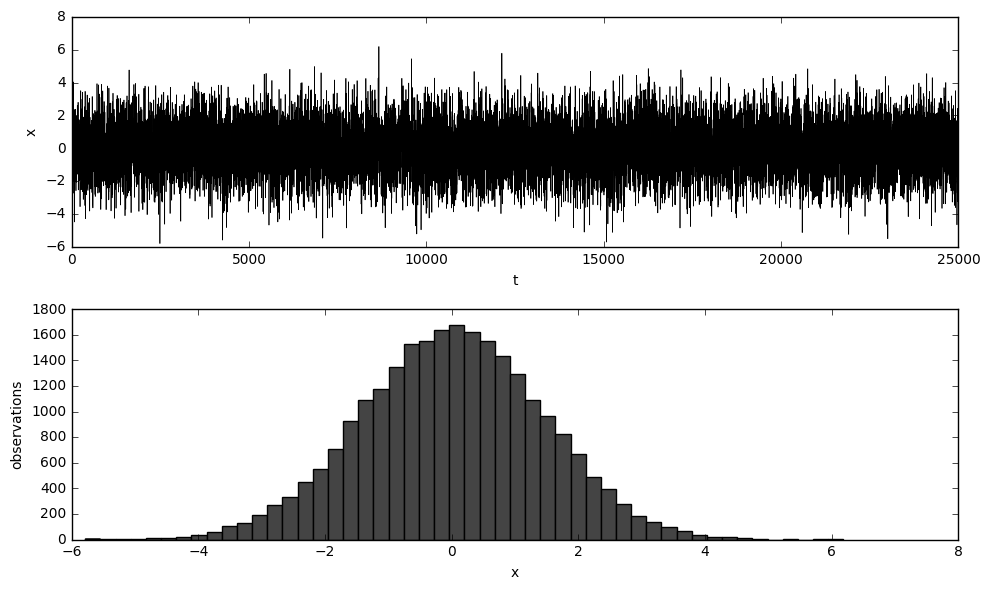

In [54]:
x = simulate(T + T_, phi, theta, init, plot=1)
x_true = x.copy()
x = x[:T] # We'll only use the first T observations to estimate parameters

## GMM Estimation

Then we define a class named **gmm**, who has 2 major methods, namely **fit** and **result**. When we create an object (or model) of the class **gmm**, we initialize it with moment condition functions **momn** as well the jacobian of their mean w.r.t. the parameter vector, **deriv_momn**. When fitting our model to the data, we use the iterated gmm method, i.e. we alternately compute $\widehat{para}_n$ and weight matrix $W_n$, the major step of which undertaken by scipy's **minimize** function, a brutal minimization method (with SLSQP method using jacobian matrix). The iteration terminates either when the square of the Euclidean distance between two estimators converges within a given value, $\delta$, or it reaches an iteration threshold (set at 10 here). 

Remark 1: when iteration threshold is set at 2, this is immediately a 2-step GMM.

Remark 2: we here also estimate the asymptotic variance when fitting to the data. The derivation of this asymptotic variance estimation will be further discussed later.

In [55]:
class gmm():
    
    def __init__(self, momn, deriv_momn):
        self.n_momn     = len(momn)                                     # number of moment conditions
        self.n_para     = len(deriv_momn)                               # number of parameters
        self.momn       = momn                                          # moment conditions
        self.deriv_momn = deriv_momn                                    # derivative of the moment conditions
        self.para       = 2*np.random.rand(self.n_para)-1               # parameters, initialized at random
    
    def fit(self, x, plot=0):
        g  = lambda para: np.matrix([m(para, x) for m in self.momn])    # g is not a vector, but a matrix of the shape k * T
        gm = lambda para: np.mean(g(para), axis=1)                      # gm is a column vector
        J  = lambda para: np.asscalar(T * gm(para).T * W * gm(para))    # J is a scalar
        S  = lambda para: g(para) * g(para).T / T                       # S is the covariance matrix
        W  = np.identity(self.n_momn)                                   # W is the inverse of S
        jacobian   = lambda para: np.asarray(2 * T * gm(para).T * W * np.matrix([dm(para, x) for dm in self.deriv_momn]).T)
        iterations = 2                                                  # set 2 to make it a 2-step GMM
        
        if plot==1:
            print_len  = 14 * self.n_para + 4
            print(' '*((print_len-13)//2)+'GMM Iteration'+' '*((print_len-13)//2))
            print('='*print_len)
            print('No. Observations: {}'.format(T))
            print('='*print_len)
            print('Iter      {}'.format('        '.join(['para_{}'.format(i+1) for i in range(self.n_para)])))
            print('-'*print_len)
        
        cons = [{'type':'ineq','fun':lambda t: (1+t[i])*(1-t[i])} for i in range(self.n_para)]
        for i in range(iterations):
            temp = minimize(J, 2*np.random.rand(self.n_para)-1, method='SLSQP', constraints=cons, jac=jacobian).x
            temp /= max(np.abs(temp).max(), 1)
            delta = ((temp - self.para) ** 2).sum()
            if plot==1: print('\r{:>4}   {}   ({})'.format(i+1, '   '.join(['{: .4e}'.format(i) for i in temp]), delta), end='')
            if delta < 1e-10 or np.nan in temp: break
            self.para = temp
            W = np.linalg.inv(S(self.para))
        
        if plot == 1:
            print('\r{:>4}   {}   ({})'.format(i+1, '   '.join(['{: .4e}'.format(i) for i in self.para]), delta))
            print('-'*int(np.floor((print_len-3)/2))+'end'+'-'*int(np.ceil((print_len-3)/2)))
        
        g_star = lambda para: g(para) - gm(para)
        S_     = lambda para: g_star(para) * g_star(para).T / T
        avar   = np.linalg.inv(np.matrix([dm(self.para, x) for dm in self.deriv_momn]) * \
                               np.linalg.inv(S_(self.para)) * \
                               np.matrix([dm(self.para, x) for dm in self.deriv_momn]).T).diagonal().tolist()[0]
        
        self.J = J
        self.x = x
        self.avar = avar
                        
    def result(self, para_true):
        print('{:^46}'.format('Iterated GMM Results'))
        print('='*46)
        print('Kind      {}'.format('        '.join(['para_{}'.format(i+1) for i in range(self.n_para)])))
        print('-'*46)
        print('Estm   {}'.format('   '.join(['{: .4e}'.format(i) for i in self.para])))
        print('True   {}'.format('   '.join(['{: .4e}'.format(i) for i in para_true])))
        print('-'*46)
        print('Avar   '+'   '.join('{: .4e}'.format(v) for v in self.avar))
        print('-'*46)

Below we define the moment condition functions and the derivatives of their mean.

In [56]:
momn = [lambda para, x: (x[4:] - para[0] * x[3:-1] - para[1] * x[2:-2]),                                                               # expectation
        lambda para, x: (x[4:] - para[0] * x[3:-1] - para[1] * x[2:-2])**2 - (1 + para[2]**2),                                         # variance
        lambda para, x: (x[4:] - para[0] * x[3:-1] - para[1] * x[2:-2]) * (x[3:-1] - para[0] * x[2:-2] - para[1] * x[1:-3]) - para[2], # covariance of epsilon_t and epsilon_{t-1}
        lambda para, x: (x[4:] - para[0] * x[3:-1] - para[1] * x[2:-2]) * (x[2:-2] - para[0] * x[1:-3] - para[1] * x[0:-4]),           # covariance of epsilon_t and epsilon_{t-2}
       ]

deriv_momn = [lambda para, x: np.array([(-x[3:-1]).mean(),
                                        (-2 * x[3:-1] * (x[4:] - para[0] * x[3:-1] - para[1] * x[2:-2])).mean(),
                                        (-x[3:-1] * (x[3:-1] - para[0] * x[2:-2] - para[1] * x[1:-3]) - x[2:-2] * (x[4:] - para[0] * x[3:-1] - para[1] * x[2:-2])).mean(),
                                        (-x[3:-1] * (x[2:-2] - para[0] * x[1:-3] - para[1] * x[0:-4]) - x[1:-3] * (x[4:] - para[0] * x[3:-1] - para[1] * x[2:-2])).mean(),
                                       ]),
              lambda para, x: np.array([(-x[2:-2]).mean(),
                                        (-2 * x[2:-2] * (x[4:] - para[0] * x[3:-1] - para[1] * x[2:-2])).mean(),
                                        (-x[2:-2] * (x[3:-1] - para[0] * x[2:-2] - para[1] * x[1:-3]) - x[1:-3] * (x[4:] - para[0] * x[3:-1] - para[1] * x[2:-2])).mean(),
                                        (-x[2:-2] * (x[2:-2] - para[0] * x[1:-3] - para[1] * x[0:-4]) - x[0:-4] * (x[4:] - para[0] * x[3:-1] - para[1] * x[2:-2])).mean(),
                                       ]),
              lambda para, x: np.array([0,
                                        -2 * para[2],
                                        -1,
                                        0,
                                       ])
             ]

Initialize the gmm model with moment condition functions and the respective partial derivatives, fit it to x, and then print out the result.

In [57]:
model = gmm(momn, deriv_momn)
model.fit(x, plot=1)
print()
model.result(para)

                GMM Iteration                
No. Observations: 20000
Iter      para_1        para_2        para_3
----------------------------------------------
   2    1.9091e-01    5.6302e-02    8.1460e-01   (1.074866238949949e-08)
---------------------end----------------------

             Iterated GMM Results             
Kind      para_1        para_2        para_3
----------------------------------------------
Estm    1.9091e-01    5.6302e-02    8.1460e-01
True    2.0000e-01    5.0000e-02    8.0000e-01
----------------------------------------------
Avar    1.9905e+01    9.1790e+00    2.5171e+01
----------------------------------------------


As comparison, check the maximum likelihood estimation with the help of **statsmodels**.

In [58]:
print(sm.tsa.ARMA(x, (len(phi), len(theta))).fit().summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                20000
Model:                     ARMA(2, 1)   Log Likelihood              -28404.025
Method:                       css-mle   S.D. of innovations              1.001
Date:                Mon, 16 Jan 2017   AIC                          56818.050
Time:                        11:55:46   BIC                          56857.568
Sample:                             0   HQIC                         56830.979
                                                                              
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0026      0.017      0.155      0.876        -0.031     0.036
ar.L1.y        0.1983      0.010     20.706      0.000         0.179     0.217
ar.L2.y        0.0512      0.009      5.672      0.0

## Theoretical Asymptotic Variances of the GMM Estimator

Some assumptions:

$$
e_t'g=
\begin{bmatrix}
x_t - \phi_1 x_{t-1} - \phi_2 x_{t-2}\\
(x_t - \phi_1 x_{t-1} - \phi_2 x_{t-2})^2 - (1 + \theta_1^2)\\
(x_t - \phi_1 x_{t-1} - \phi_2 x_{t-2})(x_{t-1} - \phi_1 x_{t-2} - \phi_2 x_{t-3}) - \theta_1\\
(x_t - \phi_1 x_{t-1} - \phi_2 x_{t-2})(x_{t-2} - \phi_1 x_{t-3} - \phi_2 x_{t-4})\\
\end{bmatrix}=
\begin{bmatrix}
\epsilon_t+\theta_1\epsilon_{t-1}\\
(\epsilon_t+\theta_1\epsilon_{t-1})^2-(1+\theta_1^2)\\
(\epsilon_t+\theta_1\epsilon_{t-1})(\epsilon_{t-1}+\theta_1\epsilon_{t-2})-\theta_1\\
(\epsilon_t+\theta_1\epsilon_{t-1})(\epsilon_{t-2}+\theta_1\epsilon_{t-3})\\
\end{bmatrix},\quad
E(e_t'g)=
\begin{bmatrix}
0\\
0\\
0\\
0\\
\end{bmatrix}.
$$

where $e_t\in\mathbb{R}^{T\times1}$ is the $t^th$ basis vector. Hence, 

$$
\frac{\partial e_t'g}{\partial\beta^{\prime}}=
\begin{bmatrix}
-x_{t-1} & -x_{t-2} & 0\\
-2x_{t-1}(x_t-\phi_1 x_{t-1}-\phi_2 x_{t-2}) & -2x_{t-2}(x_t-\phi_1 x_{t-1}-\phi_2 x_{t-2}) & -2\theta_1\\
-x_{t-1}(x_{t-1} - \phi_1 x_{t-2} - \phi_2 x_{t-3}) - x_{t-2}(x_t - \phi_1 x_{t-1} - \phi_2 x_{t-2}) & -x_{t-2}(x_{t-1} - \phi_1 x_{t-2} - \phi_2 x_{t-3}) - x_{t-3}(x_t - \phi_1 x_{t-1} - \phi_2 x_{t-2}) & -1\\
-x_{t-1}(x_{t-2} - \phi_1 x_{t-3} - \phi_2 x_{t-4}) - x_{t-3}(x_t - \phi_1 x_{t-1} - \phi_2 x_{t-2}) & -x_{t-2}(x_{t-2} - \phi_1 x_{t-3} - \phi_2 x_{t-4}) - x_{t-4}(x_t - \phi_1 x_{t-1} - \phi_2 x_{t-2}) & 0\\
\end{bmatrix}.
$$

and let

$$
G=E\left(\dfrac{\partial e_t'g}{\partial \beta^{\prime}}\right)=
\begin{bmatrix}
-\mu & -\mu & 0\\
2\phi_1\gamma_0+2(\phi_2-1)\gamma_1 & 2\phi_2\gamma_0+2\phi_1\gamma_1-2\gamma_2 & -2\theta_1\\
(\phi_2-1)\gamma_0+2\phi_1\gamma_1+(\phi_2-1)\gamma_2 & \phi_1\gamma_0+(2\phi_2-1)\gamma_1+\phi_1\gamma_2-\gamma_3 & -1\\
(\phi_2-1)\gamma_1+2\phi_1\gamma_2+(\phi_2-1)\gamma_3 & -\gamma_0+\phi_1\gamma_1+2\phi_2\gamma_2+\phi_1\gamma_3-\gamma_4 & 0
\end{bmatrix}.
$$

Since

$$
\mu = 0
$$

and the autocovariances $\gamma_i$ follows

$$
\begin{cases}
\gamma_0-\phi_1\gamma_1-\phi_2\gamma_2=\theta_1(\phi_1+\theta_1)+1\\
\phi_1\gamma_0+(\phi_2-1)\gamma_1=-\theta_1\\
\gamma_k = \phi_1\gamma_{k-1} + \phi_2\gamma_{k-2},\quad k\ge 2
\end{cases}
$$

we may derive $G$ at last. 

Also, the covariance matrix of $e_t'g$ is

$$
S=E(e_t'gg'e_t)=
\begin{bmatrix}
1+\theta_1^2    & 0                         & 0                        & 0\\
0               & 2\theta_1^4+4\theta_1^2+2 & 2\theta_1^3+2\theta_1    & 0\\
0               & 2\theta_1^3+2\theta_1     & \theta_1^4+3\theta_1^2+1 & \theta_1^3+\theta_1\\
0               & 0                         & \theta_1^3+\theta_1      & \theta_1^4+2\theta_1^2+1\\
\end{bmatrix}
$$

Now with $G$ and $S$, since

$$
\sqrt{T}\ (\widehat{para} - para)\overset{d}{\to}\mathcal{N}(0,(G'S^{-1}G)^{-1}),
$$

we may derive the theoretical asymptotic variances of $\sqrt{T}\ \widehat{para}$ as follows.

In [59]:
mu = 0 # 345112251_00121231
A = np.matrix([[1,      -phi[0],  -phi[1]],
               [phi[0], phi[1]-1, 0],
               [phi[1], phi[0],   -1]
              ])
B = np.matrix([[theta[0]*(phi[0]+theta[0])+1],
               [-theta[0]],
               [0]
              ])
y = np.linalg.inv(A)*B
y0, y1, y2 = [np.asscalar(a) for a in y]
y3 = phi[0]*y2 + phi[1]*y1
y4 = phi[0]*y3 + phi[1]*y2
G = np.matrix([[-mu,                                     -mu,                                    0],
               [2*phi[0]*y0+2*(phi[1]-1)*y1,             2*phi[1]*y0+2*phi[0]*y1-2*y2,           -2*theta[0]],
               [(phi[1]-1)*y0+2*phi[0]*y1+(phi[1]-1)*y2, phi[0]*y0+(2*phi[1]-1)*y1+phi[0]*y2-y3, -1],
               [(phi[1]-1)*y1+2*phi[0]*y2+(phi[1]-1)*y3, -y0+phi[0]*y1+2*phi[1]*y2+phi[0]*y3-y4, 0]
              ])
G.round(2)

array([[ 0. ,  0. ,  0. ],
       [-1.6, -0. , -1.6],
       [-1.8, -0.8, -1. ],
       [-1.2, -1.8,  0. ]])

In [60]:
S = np.matrix([[1+theta[0]**2, 0,                             0,                           0],
               [0,             2*theta[0]**4+4*theta[0]**2+2, 2*theta[0]**3+2*theta[0],    0],
               [0,             2*theta[0]**3+2*theta[0],      theta[0]**4+3*theta[0]**2+1, theta[0]**3+theta[0]],
               [0,             0,                             theta[0]**3+theta[0],        theta[0]**4+2*theta[0]**2+1],
              ])
S.round(2)

array([[ 1.64,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  5.38,  2.62,  0.  ],
       [ 0.  ,  2.62,  3.33,  1.31],
       [ 0.  ,  0.  ,  1.31,  2.69]])

In [61]:
np.linalg.inv(G.T*np.linalg.inv(S)*G).diagonal().tolist()[0]

[21.3174392361111, 9.980590277777774, 26.878064236111097]

In [62]:
model.avar

[19.905472617664184, 9.178999415080208, 25.170769966198534]

The estimated asymptotic variance is quite close to the theory.

## Monte Carlo Simulation

Below we use the true parameters to simulate $N=10000$ times and each time we estimate a $\widehat{para}_n$.

In [63]:
N = 1000
para_mc = []
with np.errstate(divide='ignore'):
    start = time()
    for i in range(N):
        x_mc = simulate(T + T_, phi, theta, init)[:T]
        model.fit(x_mc)
        pct = i * 100 // N + 1
        now = time()
        eta = (100 - pct) / pct * (now - start)
        print('\r{:>3}% |'.format(pct)+'\u2591'*pct+' '*(100-pct)+'| ETA: {} s'.format(int(eta)), end='')
        para_mc.append(model.para)
print('\r100% |'+'\u2591'*100+'| Finished.', end='')
para_mc = np.array(para_mc)

100% |░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░| Finished.

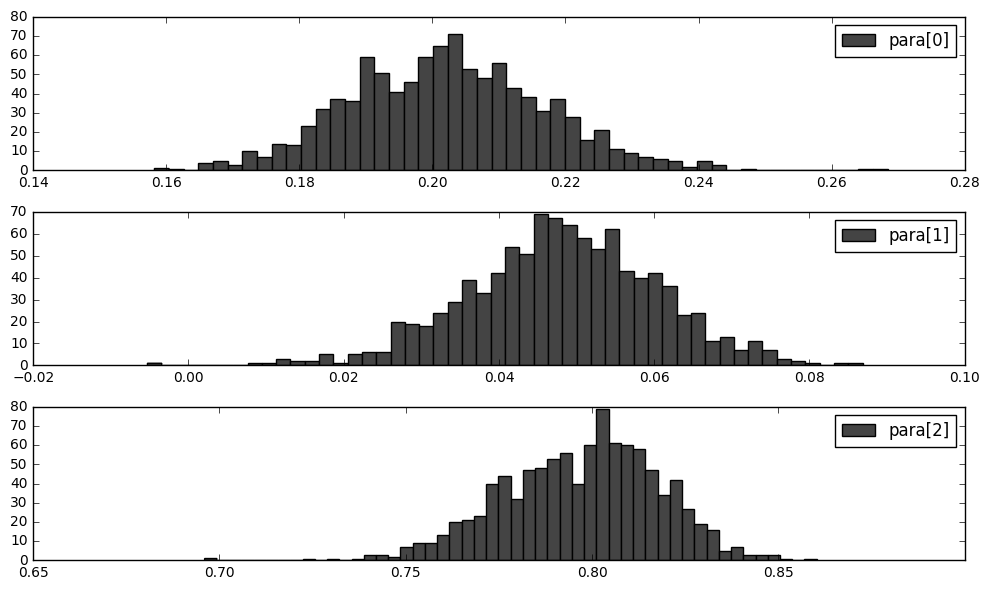

In [64]:
plt.close()
fig = plt.figure()
ax1 = fig.add_subplot(311); ax1.hist(para_mc[:,0],bins=50,color='#444444',label='para[0]'); ax1.legend()
ax2 = fig.add_subplot(312); ax2.hist(para_mc[:,1],bins=50,color='#444444',label='para[1]'); ax2.legend()
ax3 = fig.add_subplot(313); ax3.hist(para_mc[:,2],bins=50,color='#444444',label='para[2]'); ax3.legend()
plt.tight_layout()
plt.show()

In [65]:
(para_mc.var(axis=0)*T).tolist()`

[4.422402990203701, 2.9904249354938632, 8.796234771820194]

As we can see, the sample variance of the Monte Carlo simulated distribution of our estimator, is significantly smaller than the theoretical one. This should be a problem.